# Midterm 2

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 2. Pricing and Tangency Portfolio

You work in a hedge fund that believes that the AQR 4-Factor Model (present in Homework 5) is the perfect pricing model for stocks.

$$
\mathbb{E} \left[ \tilde{r}^i \right] = \beta^{i,\text{MKT}} \mathbb{E} \left[ \tilde{f}_{\text{MKT}} \right] + \beta^{i,\text{HML}} \mathbb{E} \left[ \tilde{f}_{\text{HML}} \right] + \beta^{i,\text{RMW}} \mathbb{E} \left[ \tilde{f}_{\text{RMW}} \right] + \beta^{i,\text{UMD}} \mathbb{E} \left[ \tilde{f}_{\text{UMD}} \right]
$$

The factors are available in the sheet `factors excess returns`.

The hedge fund invests in sector-tracking ETFs available in the sheet `sectors excess returns`. You are to allocate into these sectors according to a mean-variance optimization with...

* regularization: elements outside the diagonal covariance matrix divided by 2.
* modeled risk premia: expected excess returns given by the factor model rather than just using the historic sample averages.

You are to train the portfolio and test out-of-sample. The timeframes should be:
* Training timeframe: Jan-2018 to Dec-2022.
* Testing timeframe: Jan-2023 to most recent observation.

In [32]:
import sys
sys.path.insert(0,'../port_management_helper')

import helper as pmh
import datetime

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re


FILEIN = "data/midterm_2_data.xlsx"
STOCKS_SHEET = "sector excess returns"
FACTORS_SHEET = "factors excess returns"

stocks_excess_returns = pmh.read_excel_default(FILEIN, sheet_name=STOCKS_SHEET)
factors_excess_returns = pmh.read_excel_default(FILEIN, sheet_name=FACTORS_SHEET)

AQR_FACTORS = ['MKT', 'RMW', 'HML', 'UMD']

COV_MATRIX = 1/2
TESTING_FACTOR_PREMIA = False

USE_INTERCEPT = False
TRAINING_START = "2018"
TRAINING_END = "2022"
TESTING_START = "2023"
TESTING_END = "2024"

SAMPLE_ETFS = ['Agric', 'Food', 'Soda']

aqr_factors_excess_returns = factors_excess_returns[AQR_FACTORS]

training_stocks_excess_returns = stocks_excess_returns.loc[TRAINING_START:TRAINING_END]
training_aqr_factors_excess_returns = aqr_factors_excess_returns.loc[TRAINING_START:TRAINING_END]

testing_stocks_excess_returns = stocks_excess_returns.loc[TESTING_START:TESTING_END]
testing_aqr_factors_excess_returns = aqr_factors_excess_returns.loc[TESTING_START:TESTING_END]

if TESTING_FACTOR_PREMIA:
    factor_premia_returns = testing_aqr_factors_excess_returns.copy()
else:
    factor_premia_returns = training_aqr_factors_excess_returns.copy()


### 2.1.
(8pts)

Calculate the model-implied expected excess returns of every asset.

The time-series estimations should...
* NOT include an intercept. (You assume the model holds perfectly.)
* use data from the `training` timeframe.

With the time-series estimates, use the `training` timeframe's sample average of the factors as the factor premia. Together, this will give you the model-implied risk premia, which we label as
$$
\lambda_i := \mathbb{E}[\tilde{r}_i]
$$

* Store $\lambda_i$ and $\boldsymbol{\beta}^i$ for each asset.
* Print $\lambda_i$ for `Agric`, `Food`, `Soda`

***

## For a Single asset

- 1. Calculate the time-series $\beta$'s for that asset.

$$
\hat{\tilde{r}}_{\text{Agric}, t} =
\hat{\beta}_{\text{MKT}, \text{Agric}} \ \tilde{r}_{\text{MKT}, t}
+ \hat{\beta}_{\text{HML}, \text{Agric}} \ \tilde{r}_{\text{HML}, t}
+ \hat{\beta}_{\text{RMW}, \text{Agric}} \ \tilde{r}_{\text{RMW}, t}
+ \hat{\beta}_{\text{UML}, \text{Agric}} \ \tilde{r}_{\text{UML}, t}
$$

- 2. State the premium of the factors: in our case, we use the historical time-series means of the training sample.

$$
\mathbb{E} \left[ \tilde{f}_{\text{MKT}} \right] = \hat{\mu}_{\text{MKT}}
$$

$$
\mathbb{E} \left[ \tilde{f}_{\text{HML}} \right] = \hat{\mu}_{\text{HML}}
$$

$$
\mathbb{E} \left[ \tilde{f}_{\text{UML}} \right] = \hat{\mu}_{\text{UML}}
$$

$$
\mathbb{E} \left[ \tilde{f}_{\text{RMW}} \right] = \hat{\mu}_{\text{RMW}}
$$

- 3. Multiply $\beta$'s by premium and sum.

$$
\hat{\lambda}_{\text{Agric}} =
\hat{\beta}_{\text{MKT}, \text{Agric}} \ \hat{\mu}_{\text{MKT}}
+ \hat{\beta}_{\text{HML}, \text{Agric}} \ \hat{\mu}_{\text{HML}}
+ \hat{\beta}_{\text{RMW}, \text{Agric}} \ \hat{\mu}_{\text{RMW}}
+ \hat{\beta}_{\text{UML}, \text{Agric}} \ \hat{\mu}_{\text{UML}}
$$

What is the advantage of doing that vs. predicting each stock individually?

- Factors have a higher degree of predictability and stability.
- Your predictions will be unbiased, since they all map from the same $\hat{f}$

In [2]:
time_series_regression = pmh.calc_regression(
    training_stocks_excess_returns['Agric'], training_aqr_factors_excess_returns,
    intercept=False, annual_factor=12
)
time_series_regression

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,Alpha,Annualized Alpha,R-Squared,MKT Beta,RMW Beta,HML Beta,UMD Beta,Information Ratio,Annualized Information Ratio,Tracking Error,Annualized Tracking Error,Fitted Mean,Annualized Fitted Mean
Agric no Intercept,-,-,0.5447,0.8324,-0.5021,0.5565,0.0390,-,-,0.0462,0.1600,0.0037,0.0439


In [3]:
time_series_factor_means = training_aqr_factors_excess_returns.mean().to_frame('Mean').T
time_series_factor_means

,MKT,RMW,HML,UMD
Mean,0.0075,0.0051,-0.0003,0.0039


In [4]:
premium_related_to_mkt = time_series_regression['MKT Beta'].values[0] * time_series_factor_means['MKT'].values[0]
print(f"Premium related to MKT: {premium_related_to_mkt:.4f}; Annualized Premium related to MKT: {(premium_related_to_mkt*12):.4f}")

Premium related to MKT: 0.0063; Annualized Premium related to MKT: 0.0751


In [5]:
premium_related_to_rmw = time_series_regression['RMW Beta'].values[0] * time_series_factor_means['RMW'].values[0]
premium_related_to_hml = time_series_regression['HML Beta'].values[0] * time_series_factor_means['HML'].values[0]
premium_related_to_umd = time_series_regression['UMD Beta'].values[0] * time_series_factor_means['UMD'].values[0]

stock_premium = premium_related_to_mkt + premium_related_to_rmw + premium_related_to_hml + premium_related_to_umd
print(f"Annualized Premia related to RMW: {(premium_related_to_rmw*12):.4f}; HML: {premium_related_to_hml*12:.4f}; UMD: {premium_related_to_umd*12:.4f}")
print(f"Stock Premium: {stock_premium:.4f}; Stock Annualized Premium: {(stock_premium*12):.4f}")

Annualized Premia related to RMW: -0.0309; HML: -0.0022; UMD: 0.0018
Stock Premium: 0.0037; Stock Annualized Premium: 0.0439


***

In [6]:
iterative_factor_regressions = (
    pmh.calc_iterative_regression(
        training_stocks_excess_returns,
        training_aqr_factors_excess_returns,
        intercept=USE_INTERCEPT,
        keep_columns=["Beta", "Alpha"],
        drop_columns=["Annualized Alpha"],
        warnings=False
    )
    .reset_index()
    .assign(index=lambda df: df['index'].map(lambda x: x.replace(' no Intercept', '')))
    .rename({'index': None}, axis=1)
    .set_index(None)
)

premia_and_expected_excess_returns = (
    iterative_factor_regressions
    .assign(**{
        f"{factor} Premia": (lambda df, factor=factor: df[f"{factor} Beta"] * factor_premia_returns[f"{factor}"].mean())
        for factor in AQR_FACTORS
    })
    .assign(**{"Expected Return": lambda df: df[
        [f + " Premia" for f in AQR_FACTORS]
    ].sum(axis=1)})
    .drop('Alpha', axis=1)
    .assign(**{
        f"Annualized {premia}": (lambda df, premia=premia: df[f"{premia}"] * 12)
        for premia in [f + " Premia" for f in AQR_FACTORS] + ["Expected Return"]
    })
)

(
    premia_and_expected_excess_returns
    .iloc[:3]
    .loc[:, ['Expected Return', 'Annualized Expected Return']]
)

,Expected Return,Annualized Expected Return
Agric,0.0037,0.0439
Food,0.0055,0.0655
Soda,0.0073,0.0880


In [7]:
stocks_expected_excess_return = premia_and_expected_excess_returns['Expected Return']

### 2.2.

Use the expected excess returns derived from (2.1) with the **regularized** covariance matrix to calculate the weights of the tangency portfolio.

- Use the covariance matrix only for `training` timeframe.
- Calculate and store the vector of weights for all the assets.
- Return the weights of the tangency portfolio for `Agric`, `Food`, `Soda`.

$$
\textbf{w}_{t} = \dfrac{\tilde{\Sigma}^{-1} \bm{\lambda}}{\bm{1}' \tilde{\Sigma}^{-1} \bm{\lambda}}
$$

Where $\tilde{\Sigma}^{-1}$ is the regularized covariance-matrix.

***

Generally, we calculate the tangency portfolio with the vector of historical returns.

We use historical returns because we assume that, going forward those averages will be maintained. In reality, that is not a good assumption, but serves as a simplificaiton when learning about MV optimization.

A more common approach is to use ML or factor models to derive $\mathbb{E}[\tilde{r}_{t+1}]$. In this case, we are using factor models.

Using the vector of expected returns instead of the vector of historical returns only changes which vector is being applied in calculation.

In this case $\bm{\lambda}$ is composed of:

$$
\lambda_i = \hat{\beta}_{\text{MKT}, i} \ \hat{\mu}_{\text{MKT}}
+ \hat{\beta}_{\text{HML}, i} \ \hat{\mu}_{\text{HML}}
+ \hat{\beta}_{\text{RMW}, i} \ \hat{\mu}_{\text{RMW}}
+ \hat{\beta}_{\text{UML}, i} \ \hat{\mu}_{\text{UML}},
\quad \text{for} \ i = 1, 2, \ldots, n
$$

Which was calculated in (2.1)

In [8]:
lambda_vector = premia_and_expected_excess_returns['Expected Return']
lambda_vector.head(5)

Agric   0.0037
Food    0.0055
Soda    0.0073
Beer    0.0071
Smoke   0.0051
Name: Expected Return, dtype: float64

In [9]:
sigma_matrix = training_stocks_excess_returns.cov()
sigma_matrix.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Agric,0.0047,0.0017,0.0014,0.0014,0.0018,0.0031,0.0031,0.0035,0.0011,0.0028,...,0.0025,0.0030,0.0029,0.0021,0.0025,0.0033,0.0023,0.0040,0.0029,0.0025
Food,0.0017,0.0021,0.0017,0.0017,0.0021,0.0020,0.0017,0.0023,0.0016,0.0020,...,0.0018,0.0023,0.0022,0.0017,0.0018,0.0022,0.0018,0.0024,0.0019,0.0018
Soda,0.0014,0.0017,0.0027,0.0020,0.0019,0.0023,0.0017,0.0025,0.0019,0.0023,...,0.0021,0.0026,0.0023,0.0014,0.0023,0.0024,0.0020,0.0030,0.0021,0.0021
Beer,0.0014,0.0017,0.0020,0.0023,0.0017,0.0021,0.0017,0.0022,0.0018,0.0022,...,0.0019,0.0024,0.0023,0.0018,0.0022,0.0022,0.0018,0.0026,0.0021,0.0019
Smoke,0.0018,0.0021,0.0019,0.0017,0.0046,0.0021,0.0016,0.0028,0.0018,0.0021,...,0.0019,0.0025,0.0023,0.0011,0.0017,0.0028,0.0019,0.0029,0.0022,0.0022


In [10]:
tangency_weights_non_normalized = np.linalg.inv(sigma_matrix) @ lambda_vector # The different part
tangency_weights_non_normalized

array([ 2.97601882e-01, -2.20765805e+00,  4.44047208e+00, -4.37465539e+00,
       -7.92317537e-02,  1.83048358e-01,  1.56271234e-01,  1.13920823e+00,
        3.95645704e+00, -2.92498816e-01, -4.77419095e+00, -7.18327370e-01,
        5.44440599e-01, -7.34593620e-01, -1.82732340e+00, -3.94664778e-01,
        1.18632540e-01,  1.95981637e+00,  4.42306091e-01, -3.38096995e-01,
        3.13021802e+00, -6.22413103e+00,  5.24415647e-01, -1.68264875e-03,
        1.97290151e+00,  4.26077528e-01, -5.81862636e-01,  1.63670534e-01,
        8.48335649e-01, -1.10155088e+00, -4.48840384e-01, -1.69190026e+00,
       -3.80770931e-01,  1.57364501e+00, -4.19029622e+00, -1.55435295e+00,
        3.28527151e+00,  8.55074270e+00, -1.72660200e+00, -2.74036685e+00,
        9.29368175e-01,  7.85726915e-01,  2.24738503e+00, -3.34853575e-01,
        1.55737327e+00,  3.03540582e+00, -2.49008907e+00,  8.43318701e-01,
       -1.04234548e-01])

In [11]:
tangency_weights = tangency_weights_non_normalized / np.sum(tangency_weights_non_normalized)
tangency_weights

array([ 7.83299858e-02, -5.81064283e-01,  1.16874972e+00, -1.15142650e+00,
       -2.08541092e-02,  4.81790477e-02,  4.11312035e-02,  2.99844088e-01,
        1.04135505e+00, -7.69868388e-02, -1.25658584e+00, -1.89066589e-01,
        1.43298907e-01, -1.93347930e-01, -4.80958706e-01, -1.03877322e-01,
        3.12245511e-02,  5.15831376e-01,  1.16416703e-01, -8.89884587e-02,
        8.23885695e-01, -1.63821577e+00,  1.38028261e-01, -4.42879768e-04,
        5.19275437e-01,  1.12145281e-01, -1.53148534e-01,  4.30787282e-02,
        2.23285279e-01, -2.89932523e-01, -1.18136554e-01, -4.45314802e-01,
       -1.00220407e-01,  4.14189555e-01, -1.10290245e+00, -4.09111811e-01,
        8.64696382e-01,  2.25058911e+00, -4.54448438e-01, -7.21275334e-01,
        2.44613359e-01,  2.06806414e-01,  5.91520578e-01, -8.81347778e-02,
        4.09906771e-01,  7.98930750e-01, -6.55401236e-01,  2.21964799e-01,
       -2.74349430e-02])

In [12]:
sigma_matrix_regularized = .5 * (sigma_matrix) + 0.5 * np.diag(np.diag((sigma_matrix)))
tangency_regularized_weights_non_normalized = np.linalg.inv(sigma_matrix_regularized) @ lambda_vector # The different part
tangency_regularized_weights = tangency_regularized_weights_non_normalized / np.sum(tangency_regularized_weights_non_normalized)
tangency_regularized_weights

array([-0.03072272,  0.01532022,  0.13294448,  0.0794213 ,  0.01232287,
       -0.04121222, -0.03177508, -0.09201355,  0.15358104,  0.04322453,
       -0.07023518,  0.06794265,  0.08805809,  0.04840813,  0.01060708,
       -0.03147035,  0.03555326,  0.09091411, -0.00813041, -0.03979045,
        0.02091727, -0.04989693, -0.0055181 , -0.04641736, -0.03523386,
        0.13938576,  0.04874713,  0.00146424,  0.01434154, -0.04770273,
        0.07809579, -0.0830775 ,  0.0464812 , -0.0195056 ,  0.00819032,
        0.06006094,  0.16208415,  0.09467176,  0.02061061, -0.00446882,
       -0.02015532,  0.05533222,  0.06031603,  0.07199035, -0.02780317,
        0.05284672, -0.072917  ,  0.02022973,  0.02398281])

***

In [13]:
training_tangency_weights_expected_returns = pmh.calc_tangency_weights(
    training_stocks_excess_returns,
    cov_mat=COV_MATRIX,
    expected_returns=stocks_expected_excess_return,
    name="AQR Expected Returns"
)
training_tangency_weights_expected_returns.iloc[:3]

,AQR Expected Returns Weights
Agric,-0.0307
Food,0.0153
Soda,0.1329


### 2.3.

Evaluate the performance of this allocation in the `testing` period. Report the **annualized**
- mean
- vol
- Sharpe

***

Calculating performance in the out-of-sample can be done by using the vector of weights:

$$
\tilde{r}_{\text{port}} = \bf{R}_{\text{testing}} \bf{w}_{\text{tang}}
$$

Where $\bf{R} \in \mathbb{R}^{m \times n}$ and $\bf{w}_{\text{tang}} \in \mathbb{R}^{n}$, being $n$ the number of assets and $m$ the number of testing observations.

In [14]:
testing_portfolio_returns = testing_stocks_excess_returns @ tangency_regularized_weights
testing_portfolio_returns

date
2023-01-01   -0.0114
2023-02-01   -0.0177
2023-03-01    0.0873
2023-04-01    0.0232
2023-05-01   -0.0153
2023-06-01    0.0331
2023-07-01    0.0040
2023-08-01   -0.0232
2023-09-01   -0.0598
2023-10-01    0.0100
2023-11-01    0.0754
2023-12-01    0.0200
2024-01-01    0.0029
2024-02-01    0.0406
2024-03-01    0.0344
2024-04-01   -0.0071
2024-05-01    0.0203
2024-06-01    0.0139
2024-07-01    0.0147
2024-08-01    0.0567
dtype: float64

In [ ]:
print(
    f"Portfolio Mean Testing Returns: "
    + f"{testing_portfolio_returns.mean():.1%} ({testing_portfolio_returns.mean()*12:.1%})"
)
print(
    f"Portfolio Mean Testing Volatility: "
    + f"{testing_portfolio_returns.std():.1%} ({testing_portfolio_returns.std()*np.sqrt(12):.1%})"
)
print(
    f"Portfolio Mean Testing Sharpe: "
    + f"{(testing_portfolio_returns.mean() / testing_portfolio_returns.std()):.2f} "
    + f"({(testing_portfolio_returns.mean() / testing_portfolio_returns.std())*np.sqrt(12):.2f})"
)

Portfolio Mean Testing Returns: 1.5% (18.1%)
Portfolio Mean Testing Volatility: 3.5% (12.0%)
Portfolio Mean Testing Volatility: 0.44 (1.52)


***

In [16]:
aqr_portfolio = pmh.create_portfolio(
    testing_stocks_excess_returns,
    training_tangency_weights_expected_returns.iloc[:, 0].to_dict(),
    port_name="AQR Portfolio"
)
aqr_portfolio.tail(3)
aqr_portfolio_statistics = pmh.calc_summary_statistics(
    aqr_portfolio,
    annual_factor=12,
    provided_excess_returns=True,
    keep_columns=["Annualized Mean", "Annualized Vol", "Annualized Sharpe"],
)
aqr_portfolio_statistics

,Annualized Mean,Annualized Vol,Annualized Sharpe
AQR Portfolio,0.1812,0.1195,1.5155


### 2.4.

(7pts)

Construct the same tangency portfolio as in `2.2` but with one change:
* replace the risk premia of the assets, (denoted $\lambda_i$) with the sample averages of the excess returns from the `training` set.

So instead of using $\lambda_i$ suggested by the factor model (as in `2.1-2.3`) you're using sample averages for $\lambda_i$.

- Return the weights of the tangency portfolio for `Agric`, `Food`, `Soda`.

Evaluate the performance of this allocation in the `testing` period. Report the **annualized**
- mean
- vol
- Sharpe

In [17]:
training_tangency_weights_historical_returns = pmh.calc_tangency_weights(
    training_stocks_excess_returns,
    cov_mat=COV_MATRIX,
    name="Historical"
)
(
    pd.concat([
        training_tangency_weights_historical_returns, training_tangency_weights_expected_returns
    ], axis=1)
    .iloc[:3]
)

,Historical Weights,AQR Expected Returns Weights
Agric,0.1441,-0.0307
Food,-0.0698,0.0153
Soda,0.3227,0.1329


In [18]:
historical_returns_portfolio = pmh.create_portfolio(
    testing_stocks_excess_returns,
    training_tangency_weights_historical_returns.iloc[:, 0].to_dict(),
    port_name="Historical Returns Portfolio"
)
historical_returns_portfolio.tail(3)
historical_returns_portfolio_statistics = pmh.calc_summary_statistics(
    historical_returns_portfolio,
    annual_factor=12,
    provided_excess_returns=True,
    keep_columns=["Annualized Mean", "Annualized Vol", "Annualized Sharpe"],
)
pd.concat([
    historical_returns_portfolio_statistics,
    aqr_portfolio_statistics
])

,Annualized Mean,Annualized Vol,Annualized Sharpe
Historical Returns Portfolio,0.1768,0.1530,1.1555
AQR Portfolio,0.1812,0.1195,1.5155


### 2.5.

Which allocation performed better in the `testing` period: the allocation based on premia from the factor model or from the sample averages?

Why might this be?

<span style='color: red;'>

The allocation based on the premia from the factor model performs better than the sample averages.

Generally, we can state that historical returns are bad proxy for expected future returns.

On the other hand, generally, historical returns of factors are a better proxy for expected future factor returns. Expected returns (expected premia) of factor models are model stable, leading to better prediction of stock returns, conditional on the stability in the relationship between the factors and the assets ($\beta_i$). Focusing on factor estimation allows us to estimate the systematic risk component of assets, which is considered the only risk that has a premium.

The fact that the expected return model outperformed the historical return model does not imply that the factor model is a perfect pricing model.

**Extra**
- Numerous studies have demonstrated that portfolios constructed using factor-based expected returns outperform those using historical returns, particularly out-of-sample.
- Expected returns from factor models tend to be less extreme compared to historical averages of assets. Thus the expected return of assets also tend to be less extreme when using the factor-based model, thus providing less instability in the Mean-Variance optimization.

</span>

### 2.6.
Suppose you now want to build a tangency portfolio solely from the factors, without using the sector ETFs.

- Calculate the weights of the tangency portfolio using `training` data for the factors.
- Again, regularize the covariance matrix of factor returns by dividing off-diagonal elements by 2.

Report, in the `testing` period, the factor-based tangency stats **annualized**...
- mean
- vol
- Sharpe


In [19]:
pmh.calc_summary_statistics(
    pmh.create_portfolio(
        testing_aqr_factors_excess_returns,
        pmh.calc_tangency_weights(
            training_aqr_factors_excess_returns, cov_mat=COV_MATRIX,
            expected_returns=training_aqr_factors_excess_returns.mean()
        ).iloc[:, 0].to_dict(),
        port_name="Tangency Portfolio Factors"
    ),
    annual_factor=12,
    provided_excess_returns=True,
    keep_columns=["Annualized Mean", "Annualized Vol", "Annualized Sharpe"],
)

,Annualized Mean,Annualized Vol,Annualized Sharpe
Tangency Portfolio Factors,0.0624,0.0582,1.0719


### 2.7.

Based on the hedge fund's beliefs, would you prefer to use the ETF-based tangency or the factor-based tangency portfolio? Explain your reasoning. Note that you should answer based on broad principles and not on the particular estimation results.

<span style='color: red;'>

I would prefer to use the ETF-based tangency. The fact that the tangency portfolio with factors performs significantly worst than the ETF-based tangency is evidence that the AQR pricing factor model is probably not a perfect pricing model.

If the AQR pricing model was the perfect pricing model, a tangency portfolio only with the factors should produce the best adjusted by risk return out-of-sample. This sample, as well as our analysis in homework, shows that neither the AQR nor other factor models showcased perform well in the cross-sectional or time-series tests. Thus, the addition of other assets to the portfolio might can help include systematic risk with premium to the portfolio, possibly increasing the out-of-sample Sharpe.

</span>

***

# Would this strategy outperform?

In [ ]:
def calc_optimal_weights(
        training_stocks_excess_returns,
        training_factors_excess_returns,
        factor_names=None,
        cov_mat=1/2,
        name=None
    ):
    if factor_names is None:
        factor_names = list(training_factors_excess_returns.columns)
    iterative_factor_regressions = (
        pmh.calc_iterative_regression(
            training_stocks_excess_returns,
            training_factors_excess_returns,
            intercept=False,
            keep_columns=["Beta", "Alpha"],
            drop_columns=["Annualized Alpha"],
            warnings=False
        )
        .reset_index()
        .assign(index=lambda df: df['index'].map(lambda x: x.replace(' no Intercept', '')))
        .rename({'index': None}, axis=1)
        .set_index(None)
    )
    premia_and_expected_excess_returns = (
        iterative_factor_regressions
        .assign(**{
            f"{factor} Premia": (lambda df, factor=factor: df[f"{factor} Beta"] * training_factors_excess_returns[f"{factor}"].mean())
            for factor in factor_names
        })
        .assign(**{"Expected Return": lambda df: df[
            [f + " Premia" for f in factor_names]
        ].sum(axis=1)})
        .drop('Alpha', axis=1)
        .assign(**{
            f"Annualized {premia}": (lambda df, premia=premia: df[f"{premia}"] * 12)
            for premia in [f + " Premia" for f in factor_names] + ["Expected Return"]
        })
    )
    stocks_expected_excess_return = (
        premia_and_expected_excess_returns
        .loc[:, ['Expected Return']]
    )
    training_tangency_weights_expected_returns = pmh.calc_tangency_weights(
        training_stocks_excess_returns,
        cov_mat=cov_mat,
        expected_returns=stocks_expected_excess_return['Expected Return'],
        name=name if name is not None else "Factor Portfolio"
    )
    return training_tangency_weights_expected_returns

In [21]:
TRAINING_SIZE = 60
FACTORS = ['HML', 'MKT', 'SMB']

if False:
    dynamic_wts_factors = pd.DataFrame({})
    dynamic_wts_historical = pd.DataFrame({})

    factors_excess_returns = pmh.read_excel_default('data/factor_pricing_data.xlsx', sheet_name=1)

    forecasting_dates = factors_excess_returns.loc['2010':].index
    for forecasting_date in forecasting_dates:
        training_factors = (
            factors_excess_returns
            .loc[lambda df: df.index < forecasting_date]
            .iloc[-TRAINING_SIZE:]
        )
        training_stocks = (
            stocks_excess_returns
            .loc[lambda df: df.index < forecasting_date]
            .iloc[-TRAINING_SIZE:]
        )
        weights_factor_model = calc_optimal_weights(training_stocks, training_factors, cov_mat=1/2)
        weights_historical_model = pmh.calc_tangency_weights(training_stocks, cov_mat=1/2)
        
        dynamic_wts_factors = pd.concat([
            dynamic_wts_factors,
            weights_factor_model.transpose().set_axis([forecasting_date], axis=0),
        ], axis=0)
        dynamic_wts_historical = pd.concat([
            dynamic_wts_historical,
            weights_historical_model.transpose().set_axis([forecasting_date], axis=0),
        ], axis=0)

In [22]:
if False:
    factors_portfolio = (
        stocks_excess_returns
        .loc[lambda df: df.index.isin(dynamic_wts_factors.index.values)]
        .pipe(lambda df: df * dynamic_wts_factors)
        .sum(axis=1)
        .to_frame('Portfolio Factors')
    )
    historical_portfolio = (
        stocks_excess_returns
        .loc[lambda df: df.index.isin(dynamic_wts_historical.index.values)]
        .pipe(lambda df: df * dynamic_wts_historical)
        .sum(axis=1)
        .to_frame('Portfolio Historical')
    )
    oos_portfolios = pd.concat([historical_portfolio, factors_portfolio], axis=1)
    pmh.calc_cummulative_returns(oos_portfolios.loc['2010':])
    pmh.calc_summary_statistics(
        oos_portfolios.loc['2010':],
        annual_factor=12,
        provided_excess_returns=True,
        keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Corr']
    )

In [67]:
TRAINING_SIZE = 100

factors_combinations = {
    'Fama-French 3 Factors': ['HML', 'MKT', 'SMB'],
    'Fama-French 5 Factors': ['HML', 'MKT', 'SMB', 'RMW', 'CMA'],
    'Fama-French Carhart': ['HML', 'MKT', 'SMB', 'UMD'],
    'AQR': ['HML', 'MKT', 'RMW', 'UMD'],
    'CAPM': ['MKT'],
    'Historical': None
}

factors_excess_returns = (
    pmh.read_excel_default('data/factor_pricing_data.xlsx', sheet_name=1)
    .assign(date=lambda df: df.index.map(lambda x: pd.to_datetime(datetime.date(x.year, x.month, 1))))
    .set_index('date')
)

oos_portfolios = pd.DataFrame({})

for model_name, factor_names in factors_combinations.items():
    dynamic_wts = pd.DataFrame({})

    forecasting_dates = factors_excess_returns.loc['2008':].index
    for forecasting_date in forecasting_dates:
        training_stocks = (
            stocks_excess_returns
            .loc[lambda df: df.index < forecasting_date]
            .iloc[-TRAINING_SIZE:]
        )

        if model_name == 'Historical':
            wts = pmh.calc_tangency_weights(training_stocks, cov_mat=1/2)
        else:
            training_factors = (
                factors_excess_returns
                .loc[:, factor_names]
                .loc[lambda df: df.index < forecasting_date]
                .iloc[-TRAINING_SIZE:]
            )
            wts = calc_optimal_weights(training_stocks, training_factors, cov_mat=1/2)
        
        dynamic_wts = pd.concat([
            dynamic_wts,
            wts.transpose().set_axis([forecasting_date], axis=0),
        ], axis=0)

    factors_portfolio = (
        stocks_excess_returns
        .loc[lambda df: df.index.isin(dynamic_wts.index.values)]
        .pipe(lambda df: df * dynamic_wts)
        .sum(axis=1)
        .to_frame(model_name)
    )
    
    oos_portfolios = pd.concat([oos_portfolios, factors_portfolio], axis=1)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Fama-French 3 Factors Correlation,Fama-French 5 Factors Correlation,Fama-French Carhart Correlation,AQR Correlation,CAPM Correlation,Historical Correlation
Fama-French 3 Factors,0.1101,0.1333,0.8259,1.0000,0.9178,0.9935,0.9157,0.9567,0.7355
Fama-French 5 Factors,0.0940,0.1327,0.7080,0.9178,1.0000,0.9205,0.9850,0.8685,0.8087
Fama-French Carhart,0.1072,0.1316,0.8142,0.9935,0.9205,1.0000,0.9252,0.9404,0.7687
AQR,0.0991,0.1367,0.7250,0.9157,0.9850,0.9252,1.0000,0.8701,0.8117
CAPM,0.1248,0.1489,0.8383,0.9567,0.8685,0.9404,0.8701,1.0000,0.6231
Historical,0.1240,0.1533,0.8092,0.7355,0.8087,0.7687,0.8117,0.6231,1.0000


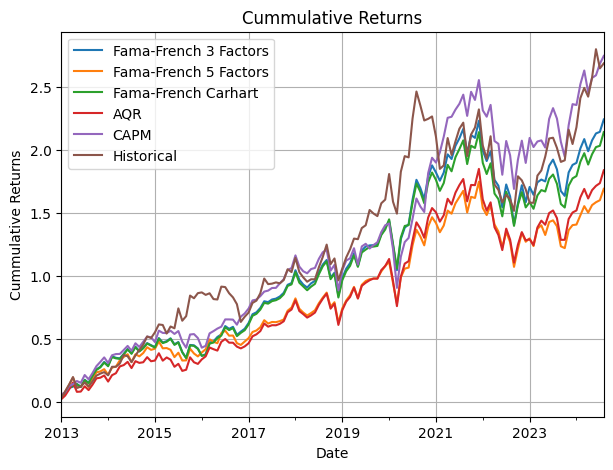

In [ ]:
pmh.calc_cummulative_returns(oos_portfolios.loc['2013':])
pmh.calc_summary_statistics(
    oos_portfolios.loc['2013':],
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe'],
    annual_factor=12,
    provided_excess_returns=True
)

In [76]:
annualized_sharpe_by_year = (
    pmh.calc_summary_statistics(
        oos_portfolios.loc['2013':],
        timeframes={f"{i}": [f"{i}", f"{i}"] for i in range(2013, 2025)},
        keep_columns='Annualized Sharpe',
        annual_factor=12,
        provided_excess_returns=True
    )
    .reset_index()
    .set_axis(['model', 'sharpe'], axis=1)
    .assign(year=lambda df: df.model.map(lambda x: int(x[-4:])))
    .assign(model=lambda df: df.model.map(lambda x: x[:-5]))
    .set_index('year')
    .pivot(values='sharpe', columns='model')
)
annualized_sharpe_by_year

model,AQR,CAPM,Fama-French 3 Factors,Fama-French 5 Factors,Fama-French Carhart,Historical
year,,,,,,
2013,1.6924,3.4637,3.1507,1.8189,3.0539,1.7599
2014,0.8981,1.2663,1.0645,1.1220,1.0849,1.9615
2015,-0.0659,0.0231,-0.0841,-0.2566,-0.0902,1.3708
2016,1.2323,1.2170,1.0346,0.8815,1.0109,-0.8723
2017,3.1869,4.6784,4.3337,3.0024,4.3019,2.2521
2018,-0.4163,-0.5080,-0.2907,-0.4328,-0.2893,-0.1251
2019,2.5132,1.9548,2.4190,2.4122,2.5522,3.6574
2020,0.9627,0.8707,0.9610,0.8963,0.9100,1.1202
2021,0.9870,1.7979,1.0186,0.9378,0.9148,0.1780


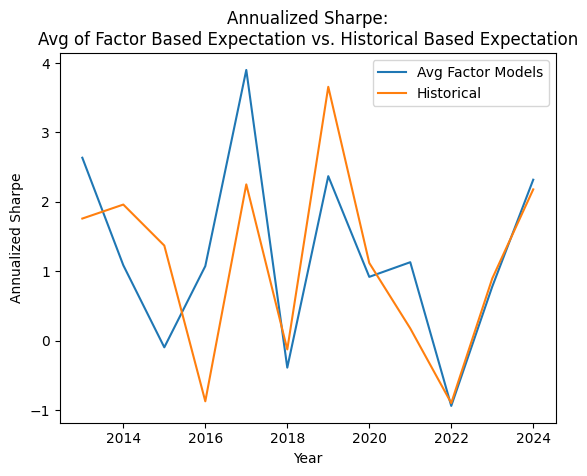

In [84]:
(
    annualized_sharpe_by_year
    .pipe(lambda df: df.drop('Historical', axis=1).mean(axis=1).to_frame('Avg Factor Models').join(df[['Historical']]))
    .plot(
        title='Annualized Sharpe:\nAvg of Factor Based Expectation vs. Historical Based Expectation',
        xlabel='Year', ylabel='Annualized Sharpe'
    )
);

***